In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
plt.rc('pdf', fonttype=42)

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

In [98]:
# Combining V100 and P100 on same row for same run
# We are deleting cases where there is no run for either of the architectures
# Every column name is appended with the name of the architecture (e.g. "_V100");
# This includes the `master_index` (e.g `master_index_V100`)

df_joined = pd.read_parquet('../df_master_joined.parquet')
df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
df_joined.shape


# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape

(78330, 116)

In [99]:
temp_col = df_joined['dram_write_throughput_P100'] + df_joined['dram_read_throughput_P100']
df_joined= df_joined[temp_col<10e9]
df_joined.shape

(6935, 244)

In [101]:
df = df_joined['dram_read_throughput_P100']; print(df.min(), df.max()/1024/1024/1024)
df = df_joined['dram_write_throughput_P100']; print(df.min(), df.max()/1024/1024/1024)
df = df_joined['dram_read_throughput_V100']; print(df.min(), df.max()/1024/1024/1024)
df = df_joined['dram_write_throughput_V100']; print(df.min(), df.max()/1024/1024/1024)

0.0 0.3185908203125
0.0 9.304160000000001
0.0 611.089
0.0 541.389


In [102]:

df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]

In [103]:
kernels = []
for i in df_joined['application_name_V100']:
    if i not in kernels:
        kernels.append(i)
        
kernels

['backprop', 'gaussian', 'hybridsort', 'kmeans', 'leukocyte', 'srad', 'stream']

## Baseline

Mean Absolute Error: 3.54
Mean Absolute Percentage Error: 18217943711781.4
R2 Score -0.009669801767939301


Text(0.5,1,'Baseline Memory Throughput - MAE: 3.54')

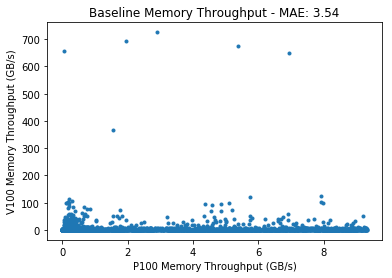

In [104]:
V100_throughput = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
P100_throughput = (df_joined['dram_read_throughput_P100'] + df_joined['dram_write_throughput_P100']).values
plt.plot(P100_throughput/1024/1024/1024, V100_throughput/1024/1024/1024,'.')
plt.xlabel('P100 Memory Throughput (GB/s)')
plt.ylabel('V100 Memory Throughput (GB/s)')
errors = abs(V100_throughput - P100_throughput)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(P100_throughput/1024/1024/1024, V100_throughput/1024/1024/1024))
print("R2 Score", r2_score(V100_throughput,P100_throughput))
plt.title('Baseline Memory Throughput - MAE: ' + str(mean_error))

#plt.savefig('Throughput_Prediction_Figures/predict_result.pdf')

In [90]:
V100_throughput.shape

(10804,)

In [91]:
max(P100_throughput/1024/1024/1024)

177.26930000000002

In [92]:
len(V100_throughput)

10804

In [93]:
len(P100_throughput)

10804

In [94]:
for i in V100_throughput:
    if 100 < i/1024/1024/1024:
        print(i/1024/1024/1024)

In [96]:
for i in P100_throughput:
    if 100 < i/1024/1024/1024:
        print(i/1024/1024/1024)

107.6164033203125
101.972755859375
103.73364375
131.4620087890625
149.27013
151.94975
158.56817
100.26440000000001
105.0994
115.0295
169.7061
130.3098
104.76396000000001
171.3648
129.0594
177.26930000000002
121.7788
100.25174
100.19005
101.81983
101.17308
100.77004
100.32767
101.26862
100.36183000000001
100.51920000000001
100.74651
103.13669
102.4901
103.69879999999999
104.35068
103.9961
102.11631
103.2954
104.30499999999999
105.15530000000001
102.18364
106.9132
105.6828
108.48570000000001
104.0816
103.20349999999999
103.83690999999999
108.975
108.5469
112.2877
113.2069
112.64489999999999
112.36090000000002
114.25380000000001
114.38400000000001
112.9771
111.62440000000001
116.31920000000001
117.3722
118.1743
113.70770000000002
121.61219999999999
119.72680000000001
118.3895
118.9215
117.5255
120.72919999999999
121.36800000000001
123.09190000000001
124.86
124.4654
123.8506
124.6225
128.3708
128.107
124.3382
129.928
128.2623
132.05800000000002
131.8579
132.351
133.7501
132.6257
133.8798
1

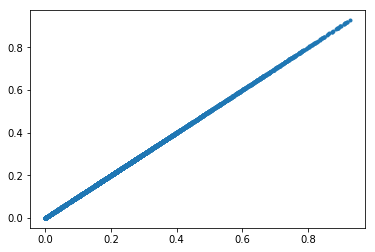

In [52]:
plt.plot(P100_throughput/1024/1024/1024, P100_throughput/1024/1024/1024,'.')

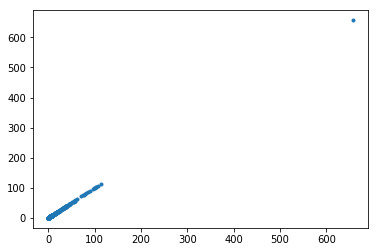

In [35]:
plt.plot(V100_throughput/1024/1024/1024, V100_throughput/1024/1024/1024,'.')

In [26]:
max(V100_throughput/1024/1024/1024)
v1 = V100_throughput/1024/1024/1024
count = 0
for i in v1:
    if 0 == i:
        count +=1
count

121

In [28]:
count = 0
for i in v1:
    if 0 != i:
        #print(i)
        count +=1
count

5065

In [12]:
max(P100_throughput/1024/1024/1024)

0.9275595703125

## Regression

In [44]:
df_target = (df_joined['dram_read_throughput_V100'] + df_joined['dram_write_throughput_V100']).values
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    1000*data,
    df_target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [45]:
df_target/1024/1024/1024

array([ 0.61720703,  0.35669043, 36.40237402, ...,  2.75958695,
        3.23506721,  0.19139453])

In [46]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [47]:
y_test_predict = clf.predict(X_test)



In [48]:
y_test_predict = clf.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
y_test_predict_gb = y_test_predict/1024/1024/1024
y_test_gb = y_test/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test_gb,y_test_predict_gb))

Mean Absolute Error: 2.26
Mean absolute percentage error: 126568385435838.88


Text(0,0.5,'Predicted')

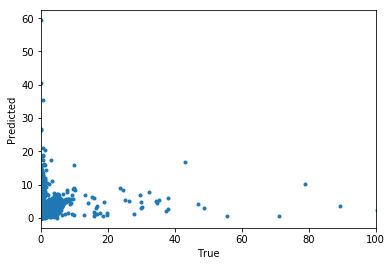

In [49]:
plt.plot(y_test/1024/1024/1024, y_test_predict/1024/1024/1024,'.')
plt.xlim(0,100)
plt.xlabel('True')
plt.ylabel('Predicted')



Text(0,0.5,'Predicted')

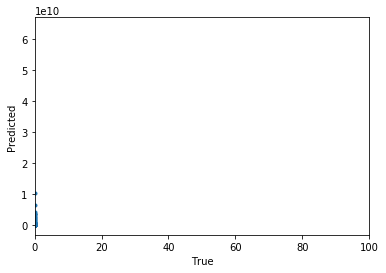

In [50]:
plt.plot(y_test, y_test_predict,'.')
plt.xlim(0,100)
plt.xlabel('True')
plt.ylabel('Predicted')

In [34]:
y_test/1024/1024/1024

array([0.24184277, 0.06330791, 1.19785   , ..., 4.26144764, 0.15665611,
       0.28125781])

In [35]:
y_test_predict/1024/1024/1024

array([0.57578376, 0.07483773, 2.47754891, ..., 2.38492788, 0.14823678,
       5.98618464])

In [38]:
error = abs(y_test/1024/1024/1024 - y_test_predict/1024/1024/1024)

In [40]:
max(error)

98.06751842783203

In [41]:
min(error)

2.570470924376407e-05

In [43]:
np.mean(error)

2.2827033370596364

In [44]:
df_joined['dram_write_throughput_P100']

unique_index
bpnn_layerforward_CUDA_-10000_bpnn_layerforward_CUDA        2.050312e+08
bpnn_adjust_weights_cuda_-10032_bpnn_adjust_weights_cuda    3.005156e+08
bpnn_layerforward_CUDA_-10032_bpnn_layerforward_CUDA        2.182223e+08
bpnn_adjust_weights_cuda_-10048_bpnn_adjust_weights_cuda    4.380143e+08
bpnn_layerforward_CUDA_-10048_bpnn_layerforward_CUDA        1.922994e+08
                                                                ...     
STREAM_Scale_N9984_STREAM_Scale                             0.000000e+00
STREAM_Triad_N9984_STREAM_Triad                             8.912057e+07
set_array_N9984_set_array                                   1.140526e+08
STREAM_Scale_N99968_STREAM_Scale                            2.695040e+08
set_array_N99968_set_array                                  1.575569e+08
Name: dram_write_throughput_P100, Length: 5186, dtype: float64

In [47]:
max(df_joined['dram_read_throughput_P100'])/1024/1024/1024

0.2154541015625

In [48]:
max(df_joined['dram_read_throughput_V100'])/1024/1024/1024

324.249

In [51]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=50000).fit(X_train, y_train)

/Users/yzamora/miniconda3/envs/python_work/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
